In [1]:
from aemeasure import read_as_pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
from pcpptc import PolygonInstance, Solution
from pcpptc.plot import setup_plot, plot_polygon_instance, plot_solution
from pcpptc.plot.polgyon_instance import plot_coverage

In [3]:
read_as_pd("./solutions2/2.results.json").columns

Loaded dataframe ./solutions2/2.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:20:25.305058 and 2021-08-23 19:12:10.324509


Index(['solution', 'coverage', 'touring_cost', 'length', 'turn_sum',
       'instance', 'instance_path', 'runtime', 'timestamp', 'hostname', 'argv',
       'git_revision', 'cwd', 'solver', 'i', 'turn_factor'],
      dtype='object')

In [4]:
tables = []
for f in os.listdir("./solutions2"):
    if not f.endswith(".results.json"):
        continue
    f = os.path.join("./solutions2", f)
    tables.append(read_as_pd(f))

data = pd.concat(tables, ignore_index=True)
data.groupby(["solver"])["instance"].nunique()
bad_instance = "./instances2/122.instance.json"
data = data[data["instance_path"] == bad_instance]

Loaded dataframe ./solutions2/75.results.json
Executed on: ['algry01']
During: 2021-08-23 21:15:25.537704 and 2021-08-23 21:18:47.477030
Loaded dataframe ./solutions2/156.results.json
Executed on: ['algry01']
During: 2021-08-23 17:28:07.922508 and 2021-08-23 17:29:58.018417
Loaded dataframe ./solutions2/119.results.json
Executed on: ['algry01']
During: 2021-08-23 21:52:15.380986 and 2021-08-23 22:01:16.874869
Loaded dataframe ./solutions2/173.results.json
Executed on: ['algry01']
During: 2021-08-23 21:37:08.068632 and 2021-08-23 21:42:46.264003
Loaded dataframe ./solutions2/144.results.json
Executed on: ['algry03' 'algry01']
During: 2021-08-20 16:24:14.480837 and 2021-08-23 19:20:55.900008
Loaded dataframe ./solutions2/185.results.json
Executed on: ['algry01']
During: 2021-08-23 22:28:15.147155 and 2021-08-23 22:31:34.907581
Loaded dataframe ./solutions2/154.results.json
Executed on: ['algry01']
During: 2021-08-23 20:02:03.554251 and 2021-08-23 20:07:16.064666
Loaded dataframe ./soluti

In [5]:
data[data.isna().any(axis=1)]

,solution,coverage,touring_cost,length,turn_sum,instance,instance_path,runtime,timestamp,hostname,argv,git_revision,cwd,solver,i,turn_factor


In [6]:
data.dropna(inplace=True)
data = data[data["solver"] != "MeshAlgorithm(0.95)"]
data.groupby(["solver"])["instance"].nunique()

solver
MeshAlgorithm(0.95, full_coverage=False)                                                                             1
MeshAlgorithm(0.95, full_coverage=True)                                                                              1
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))    1
RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))     1
Name: instance, dtype: int64

In [7]:
from optimizer.instance_converter.dmsh import GmshGrid


def rename(s):
    names = {
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=False, point_based=False, with_boundary=False))": "Regular (Partial)",
        "RotatingHexagonalAlgorithm(RotatingRegularHexagonal(full_coverage=True, point_based=False, with_boundary=False))": "Regular (Full)",
        "MeshAlgorithm(0.95, full_coverage=False)": "Mesh (Partial)",
        "MeshAlgorithm(0.95, full_coverage=True)": "Mesh (Full)",
    }
    return names.get(s, s)


data["solver"] = data["solver"].apply(rename)
data = data[data["solver"].apply(lambda s: "Full" in s)]

In [8]:
data["type"] = data["solver"].apply(lambda s: "hex" if "Hex" in s else "square")
data["point_based"] = data["solver"].apply(lambda s: "pb=True" in s)

In [9]:
instance_paths = list(data["instance_path"].unique())
instances = {f: PolygonInstance.from_json(file_path=f) for f in instance_paths}
instance_areas = pd.DataFrame(
    data={"area": [i.original_area.area for i in instances.values()]},
    index=instance_paths,
)
data = data.merge(instance_areas, left_on="instance_path", right_index=True)


def compute_objective(row):
    instance = instances[row["instance_path"]]
    solution = Solution.from_json(data=row["solution"])
    instance: PolygonInstance
    return instance.compute_touring_cost(
        solution.waypoints
    ) + instance.compute_missed_covering_value(solution.waypoints)


data["Obj"] = data.apply(compute_objective, axis=1)

In [10]:
t_ = data.groupby("instance")[["touring_cost"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_cost"] = 100 * ((data["touring_cost"] / data["touring_cost_min"]) - 1)
data["relative_coverage"] = 100 * data["coverage"] / data["area"]
data["type"] = data["solver"].apply(lambda s: s[0])

In [11]:
t_ = data.groupby("instance")[["Obj"]].min()
data = data.merge(t_, left_on="instance", right_index=True, suffixes=("", "_min"))
data["relative_obj"] = 100 * ((data["Obj"] / data["Obj_min"]) - 1)

In [12]:
data.sort_values(["solver"], inplace=True, ascending=True)
data.sort_values(["type"], inplace=True, ascending=True, kind="stable")

In [13]:
t_ = data.dropna()
t_ = t_.groupby(["solver"])["instance"].nunique()
t_

solver
Mesh (Full)       1
Regular (Full)    1
Name: instance, dtype: int64

In [14]:
t = data.groupby(["solver"])["runtime"].mean().reset_index()
t["solver"] = t["solver"].apply(lambda s: s.replace("□", "$\\square$"))
t["solver"] = t["solver"].apply(lambda s: s.replace("△", "$\\Delta$"))
t["solver"] = t["solver"].apply(lambda s: s.replace("%", "\\%"))
for i, t in t.iterrows():
    print(t["solver"], "&", round(t["runtime"], 1), "\\\\")

Mesh (Full) & 60.8 \\
Regular (Full) & 13.2 \\


Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

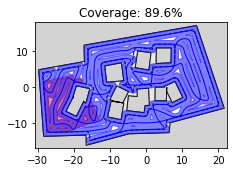

Computing coverage polygon
Plotting coverage polygon


<Figure size 432x288 with 0 Axes>

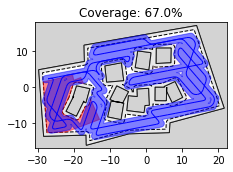

In [18]:
def plot(row, path=None, ax=None):
    instance_path = row["instance_path"]
    instance = PolygonInstance.from_json(file_path=instance_path)
    solution = Solution.from_json(data=row["solution"])
    if not ax:
        ax = setup_plot(figsize=(3.5, 2.5))
    plot_polygon_instance(ax, instance, set_limits=True, plot_valuable_areas=False)
    plot_solution(ax, solution, color="blue")
    plot_coverage(ax, instance, solution)
    ax.set_title(f"Coverage: {round(row['relative_coverage'],1)}%")
    if path:
        plt.tight_layout()
        plt.savefig(path)


for i, row in data[data["instance_path"] == bad_instance].iterrows():
    plot(row)
    plt.tight_layout()
    plt.savefig(f"08_bad_coverage_{i}.pdf")
    plt.show()